In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal
%matplotlib inline

##Import Reference Data

In [78]:
df_R = pd.read_csv(filepath_or_buffer = 'reference_data/closed_only.csv', parse_dates = [0], index_col = 0)
print df_R[:5]

                     o3_ppb
date                       
2014-07-25 23:24:00      39
2014-07-25 23:25:00      38
2014-07-25 23:26:00      37
2014-07-25 23:27:00      39
2014-07-25 23:28:00      36


In [79]:
df_R.o3_ppb = df_R.o3_ppb.shift(1)

In [81]:
df_R.head()

,o3_ppb
date,
2014-07-25 23:24:00,NaN
2014-07-25 23:25:00,39
2014-07-25 23:26:00,38
2014-07-25 23:27:00,37
2014-07-25 23:28:00,39


##Import Pod Data

In [82]:
df_P = pd.io.parsers.read_csv(filepath_or_buffer = 'pod_files/pod1_7_25.csv', parse_dates = [0], index_col = 0)
print df_P.head()

                       UnixTime  e2v03  no2  Temp    Rh
YYYY/MM/DD_HH:MM:SS                                    
2014-07-25 15:51:24  1406303484    514  783  44.6  14.1
2014-07-25 15:51:29  1406303489    514  782  44.6  14.1
2014-07-25 15:51:33  1406303493    514  782  44.5  14.1
2014-07-25 15:51:38  1406303498    513  782  44.5  14.1
2014-07-25 15:51:43  1406303503    512  782  44.6  14.1


###Resample all of the data, so that the reference and pod data are in the same dataframe, and also average over a specified time.

In [83]:
resamp_time = '1Min'

In [84]:
df_all = pd.concat([df_R.o3_ppb.resample(resamp_time), df_P.resample(resamp_time)], axis=1).dropna()
#df_all = df_P.resample(resamp_time).dropna()
print df_all[:5]

                     o3_ppb      UnixTime       e2v03         no2       Temp  \
date                                                                           
2014-07-25 15:51:00      43  1.406304e+09  513.000000  782.125000  44.562500   
2014-07-25 16:50:00      50  1.406307e+09  443.636364  710.727273  36.518182   
2014-07-25 16:51:00      37  1.406307e+09  445.461538  713.615385  36.630769   
2014-07-25 16:52:00      39  1.406307e+09  447.750000  716.333333  36.875000   
2014-07-25 16:53:00      37  1.406307e+09  448.923077  717.307692  37.138462   

                            Rh  
date                            
2014-07-25 15:51:00  14.100000  
2014-07-25 16:50:00  21.890909  
2014-07-25 16:51:00  22.015385  
2014-07-25 16:52:00  22.200000  
2014-07-25 16:53:00  22.069231  


####Create 'days since start' feature.

In [85]:
df_all['days from start'] = df_all['UnixTime']
for i in range(0,len(df_all['UnixTime'])):
    df_all['days from start'][i] = int(df_all['UnixTime'][i]- df_all['UnixTime'][0])/86400

####Drop the names from all of the data to prepare it for filtering

In [86]:
df_fit = df_all.dropna()

In [87]:
rh_sm = None
temp_sm = None
ref_o3_sm = None
pod_o3_sm = None

#Declare the data column to filter.

#Filtering

####Define functions to plot the raw and filtered data

In [88]:
def plot_data(data, title):
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111)
    ax.plot(data, marker = '.')
    ax.set_title(title)

####Define a function that filters the data.

In [89]:
def plot_filter(b):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = ax1.twinx()

    w, h = signal.freqz(b)
    w /= np.pi
    ax1.plot(w, 20 * np.log10(abs(h)), 'r-')
    ax2.plot(w[1:], -np.diff(np.unwrap(np.angle(h))), 'b-')
    ax2.set_ylim(bottom=0.)

    ax3 = fig.add_subplot(212)
    ax3.plot(w, 20 * abs(h), 'r-')

In [90]:
def hanning_window_fir_filtering(data_points, filter_minutes, y_data):
    #make a window (finite-impulse response method), 
    #second agrment is frequency in units where 1 is sampling frequency (1 means 1 cycle per minute, 0.2 is equal to a period of 5 minutes) 
    #first agrument is how many data points are in the window (frequency resolution) if you choose 100, there is a time delay by 50 data points
    samp_freq = 1.0/filter_minutes
    b = signal.firwin(data_points, samp_freq, window='hanning')
    
    impulse = np.zeros((100,))
    impulse[0] = 1.

    #replace impulse with my y values
    y = signal.lfilter(b, 1., y_data)
    
    #call the plotting functions for the filtered and raw data.
    plot_data(y_data,'Raw Data')
    plot_data(y,'Filtered Data')    
    
    #Call the impulse plotting function
    plot_filter(b)
    
    #Delete the shifted points from the new data
    y_final = np.delete(y, list(xrange(data_points)))
    
    return y_final

####Call the filtering function

Pod Data
[ 442.83704613  439.55891043  436.59678954  432.69131379  425.88671274]


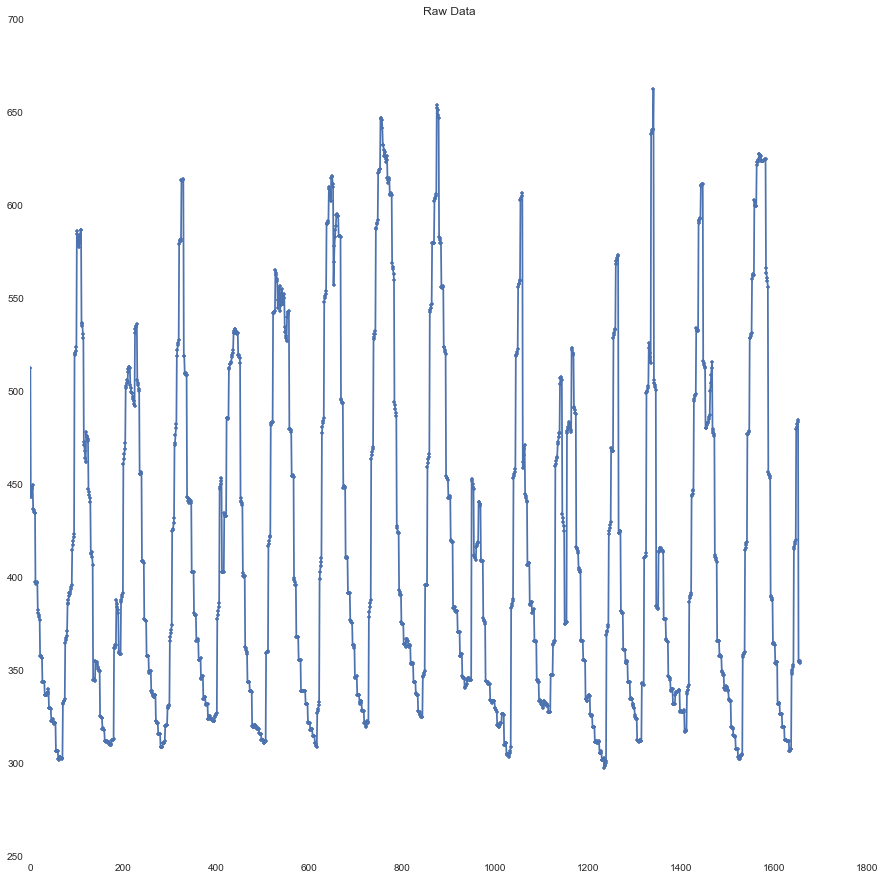

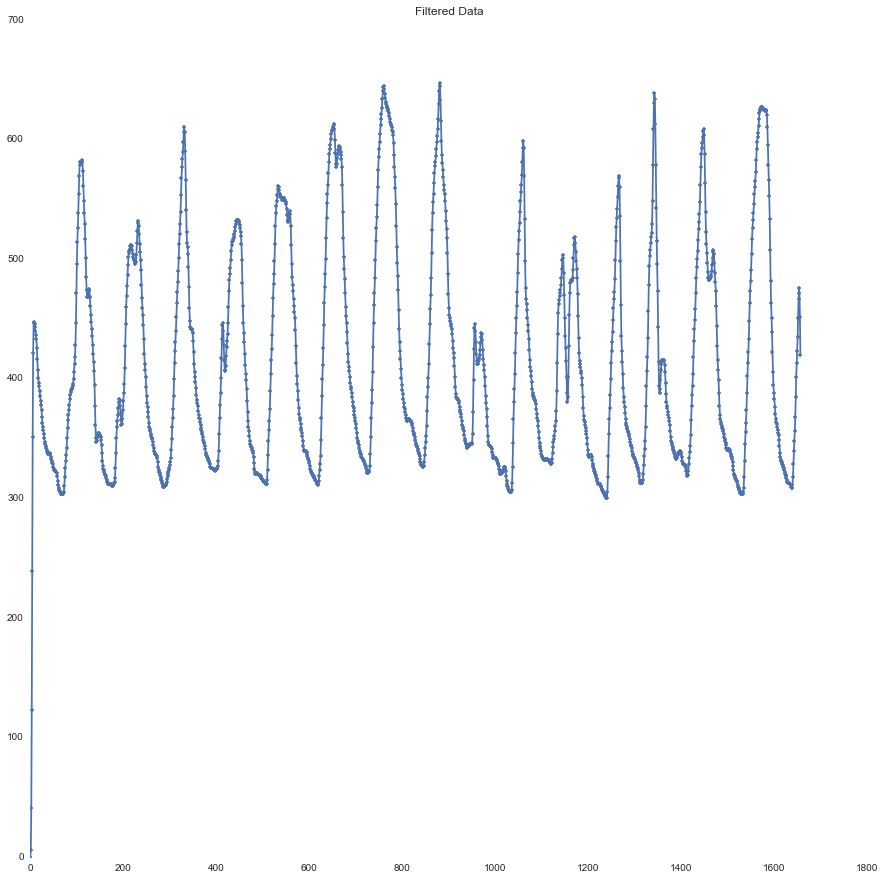

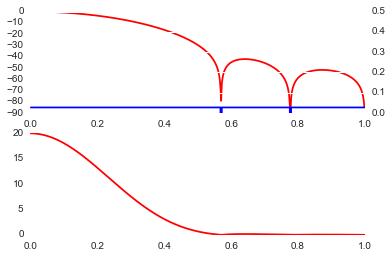

In [91]:
#Choose the number of data points in the window, and the number of minutes in the sampling period.
data_points = 10
filter_minutes = 5

#ref_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['O3_ppb'].values)
#print 'Reference Data'
#print ref_o3_sm[:25]

pod_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['e2v03'].values)
print 'Pod Data'

print pod_o3_sm[:5]

####Make a new dataframe without the offset rows, and append the new data into it.

In [92]:
df_short = df_fit.ix[data_points:]
print df_short[:5]

                     o3_ppb      UnixTime       e2v03         no2       Temp  \
date                                                                           
2014-07-25 17:58:00      39  1.406311e+09  435.000000  689.000000  36.846154   
2014-07-25 18:57:00      44  1.406315e+09  397.692308  643.153846  32.630769   
2014-07-25 18:58:00      44  1.406315e+09  397.416667  643.666667  32.783333   
2014-07-25 18:59:00      44  1.406315e+09  396.923077  643.153846  32.823077   
2014-07-25 19:00:00      42  1.406315e+09  397.923077  643.615385  32.915385   

                            Rh  days from start  
date                                             
2014-07-25 17:58:00  21.676923                0  
2014-07-25 18:57:00  27.246154                0  
2014-07-25 18:58:00  27.200000                0  
2014-07-25 18:59:00  27.076923                0  
2014-07-25 19:00:00  27.076923                0  


In [93]:
df_short['ref_o3_smooth'] = ref_o3_sm
#df_short['pod_o3_smooth'] = pod_o3_sm
print df_short[:25]

                     o3_ppb      UnixTime       e2v03         no2       Temp  \
date                                                                           
2014-07-25 17:58:00      39  1.406311e+09  435.000000  689.000000  36.846154   
2014-07-25 18:57:00      44  1.406315e+09  397.692308  643.153846  32.630769   
2014-07-25 18:58:00      44  1.406315e+09  397.416667  643.666667  32.783333   
2014-07-25 18:59:00      44  1.406315e+09  396.923077  643.153846  32.823077   
2014-07-25 19:00:00      42  1.406315e+09  397.923077  643.615385  32.915385   
2014-07-25 19:01:00      45  1.406315e+09  397.166667  644.000000  32.975000   
2014-07-25 20:01:00      43  1.406318e+09  382.461538  629.000000  30.700000   
2014-07-25 20:02:00      37  1.406319e+09  381.083333  627.000000  30.700000   
2014-07-25 20:03:00      36  1.406319e+09  380.076923  626.384615  30.700000   
2014-07-25 20:04:00      37  1.406319e+09  378.923077  624.384615  30.692308   
2014-07-25 20:05:00      37  1.406319e+0

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


##Make a csv file with the smoothed data

In [94]:
df_short.to_csv(path_or_buf = '7_25_filt_closed_only.csv')